<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/K%C3%A9pfeldolgoz%C3%A1s/ip_practice10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Image Processing practice 10__
1. Random Seeds
2. Computational Graphs & Gradient calculation
3. Modelling and Training with low level API tools


----------------------
## 0. Preparations

### 0.1. Checking GPU and CUDA availability

With the _!nvcc --version_ command we can check the CUDA version of our system. Remember, we only need exclamation mark (!) in notebooks to enable running Linux commands in code blocks.

In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


### 0.2. Installing latest torch version and tqdm for progress bars

In [8]:
!pip install torch tqdm

### Checking PyTorch version and CUDA availability from torch

In [9]:
import torch

In [10]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.0+cu121
True


--------------------------
## __1. Understanding Random Seeds__

Setting the seed of the random generator for reproducibility.

If you set a specific seed, the subsequent random numbers will be the same after each setting of the same seed. Thanks to this, if we repeatedly run a cell with random generation and the seed is set at the beginning, we will get the same random numbers.

In [11]:
import numpy as np

In [12]:
np.random.seed(42)
print(np.random.randn(2))
print(np.random.randn(2))
print()

np.random.seed(42)
print(np.random.randn(2))
print(np.random.randn(2))

[ 0.49671415 -0.1382643 ]
[0.64768854 1.52302986]

[ 0.49671415 -0.1382643 ]
[0.64768854 1.52302986]


## __2. Computational Graphs & their gradients__

### 2.1. Implementing a Computational Graph with NumPy

### Definition of the variables and functions
#### $\{a, b, c, d, e\}\;\epsilon\;\mathbb{R}^2; \;f\; \epsilon\;\mathbb{R}$

#### $\{\mathcal{F}_{(a, b)\rightarrow d}, \mathcal{F}_{(c, d)\rightarrow e}\}:\mathbb{R}^{2\times{2}}\mapsto \mathbb{R}^2\; ;\; \mathcal{F}_{e\rightarrow f}: \mathbb{R}^2\mapsto\mathbb{R}$

#### $\mathcal{F}_{(a, b)\rightarrow d}= \begin{bmatrix}2*a_1 + 0.5*b_1 \\2*a_2 + 0.5*b_2\end{bmatrix}$
#### $\mathcal{F}_{(c, d)\rightarrow e}= \begin{bmatrix}c_1 * d_1 \\c_2 * d_2\end{bmatrix}$
#### $\mathcal{F}_{e\rightarrow f}=e_1 + e_2$

------------------------
### Gradient Calculation
- If $x\;\epsilon\;\mathbb{R}^n\;;\;y\;\epsilon\;\mathbb{R}^m$, then the gradient of $\mathcal{F}_{x\rightarrow y}:\mathbb{R}^n\mapsto\mathbb{R}^m$ in case of m=1 is:

#### $\nabla\mathcal{F}_{x\rightarrow y} = \begin{bmatrix}\frac{\delta{y}}{\delta{x_1}} &\frac{\delta{y}}{\delta{x_2}} &\dots &\frac{\delta{y}}{\delta{x_n}}\end{bmatrix}$
- In case of m>1 (vector valudes function) the Jacobi matrix can be used:

#### $\nabla\mathcal{F}_{x\rightarrow y} = \begin{bmatrix}\frac{\delta{y_1}}{\delta{x_1}} & \dots & \frac{\delta{y_1}}{\delta{x_n}}\\\vdots & \ddots & \vdots\\\frac{\delta{y_m}}{\delta{x_1}} & \dots & \frac{\delta{y_m}}{\delta{x_n}}\\\end{bmatrix}$

Gradients are traced back to the input from the output based on the chain rule. In case of a multi-input function, the gradients are traced back to the inputs separately, so that when calculating the gradient for a given input, the other inputs are replaced by their values (values marked with a hat and in bold).

------------------------------
### In case of a given computational graph

#### $grad_{fe} = \nabla \mathcal{F}_{e\rightarrow f}=\begin{bmatrix}\frac{\delta{f}}{\delta{e_1}} & \frac{\delta{f}}{\delta{e_2}}\end{bmatrix}=\begin{bmatrix}1 & 1\end{bmatrix}$

#### $grad_{fc} = grad_{fe}*\nabla\mathcal{F}_{(c, d=\mathbf{\hat{d}})\rightarrow e}= grad_{fe}*\begin{bmatrix}\frac{\delta{e_1}}{\delta{c_1}} & \frac{\delta{e_1}}{\delta{c_2}}\\\frac{\delta{e_2}}{\delta{c_1}} & \frac{\delta{e_2}}{\delta{c_2}}\end{bmatrix}=\begin{bmatrix}1 & 1\end{bmatrix}*\begin{bmatrix}\mathbf{\hat{d}_0} & 0 \\ 0 & \mathbf{\hat{d}_1}\end{bmatrix}=\begin{bmatrix}\mathbf{\hat{d}_0} & \mathbf{\hat{d}_1}\end{bmatrix}$

### $grad_{fd} = grad_{fe}*\nabla\mathcal{F}_{(c=\mathbf{\hat{c}}, d)\rightarrow e}=\dots=\begin{bmatrix}\mathbf{\hat{c}_1} & \mathbf{\hat{c}_2}\end{bmatrix}$

#### $grad_{fa} = grad_{fd}*\nabla\mathcal{F}_{(a, b=\mathbf{\hat{b}})\rightarrow d}=\dots=grad_{fd}*\begin{bmatrix}2 & 0\\ 0& 2\end{bmatrix}$

#### $grad_{fb} = grad_{fd}*\nabla\mathcal{F}_{(a=\hat{\mathbf{a}}, b)\rightarrow d}=\dots=grad_{fd}*\begin{bmatrix}0.5 & 0\\ 0 & 0.5\end{bmatrix}$

In [13]:
np.random.seed(42)

a = np.random.randn(2)
b = np.random.randn(2)
c = np.random.randn(2)

d = 2*a+0.5*b
e = c*d
f = np.sum(e)

grad_fe = np.ones(2)
grad_fc = grad_fe*d
grad_fd = grad_fe*c
grad_fa = grad_fd*2
grad_fb = grad_fd*0.5

print(grad_fa)
print(grad_fb)
print(grad_fc)

[-0.46830675 -0.46827391]
[-0.11707669 -0.11706848]
[1.31727258 0.48498633]


### 2.2. Computational Graphs with PyTorch

Determining the values and gradients of the above computational graph in the PyTorch framework can be done more simply with the help of its automatic gradient tracking and the backward method. The former prescribes to store all intermediate result between the output and the tensors marked as tracked ones. The latter performs the gradient calculations from the given output tensor backwards (toward the inputs) along the graph using the chain rule.

In [14]:
np.random.seed(42)

a = torch.tensor(np.random.randn(2), requires_grad=True)
b = torch.tensor(np.random.randn(2), requires_grad=True)
c = torch.tensor(np.random.randn(2), requires_grad=True)

d = 2*a+0.5*b
e = c*d
f = torch.sum(e)

f.backward()

print(a.grad)
print(b.grad)
print(c.grad)

tensor([-0.4683, -0.4683], dtype=torch.float64)
tensor([-0.1171, -0.1171], dtype=torch.float64)
tensor([1.3173, 0.4850], dtype=torch.float64)


----------------
## __3. Implementation and Training of a Simple Linear Model with the Low Level Tools of PyTorch__

### Data generator

In [15]:
import matplotlib.pyplot as plt

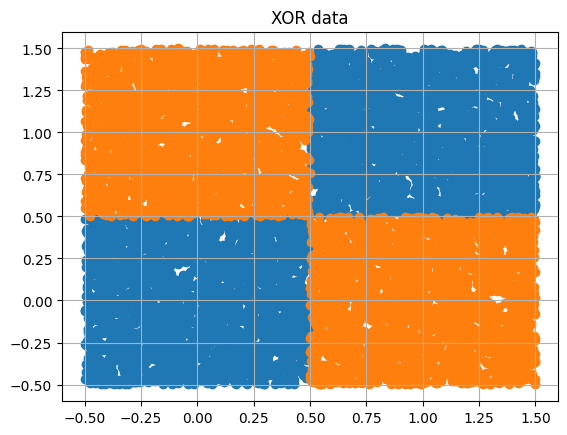

In [16]:
def create_xor_data(N):
  X = (torch.rand(N, 2)*2)-0.5

  X_round = torch.round(X)
  Y = torch.logical_xor(X_round[:, 0], X_round[:, 1])
  Y = Y.unsqueeze(-1).float() - 0.5

  return X, Y


def visualize_xor(x, y):
  plt.scatter(x[y.squeeze()<0.0, 0], x[y.squeeze()<0.0, 1])
  plt.scatter(x[y.squeeze()>0.0, 0], x[y.squeeze()>0.0, 1])
  plt.title("XOR data")
  plt.grid(True)
  plt.show()


x_train, y_train = create_xor_data(10000)
visualize_xor(x_train, y_train)

### 3.1. Defining the Linear Model

First, we implement a simple linear model at the level of abstraction where the internal operation is still sufficiently transparent. For this, we define PyTorch tensors and instead of the layers of the built-in torch.nn module, we define our own layer, in which we implement essentially a simplified (non-bias) version of the torch.nn.Linear layer with basic PyTorch operations.

The linear model essentially implements a neuron performing a linear transformation. The transformation creates a linear relationship between the input vector $x\;\epsilon\;\mathbb{R}^n$ and the output vector $y\;\epsilon\;\mathbb{R}^m$, i.e. the output values can be formulated as a linear combination of the input values.
#### $W_{x\rightarrow{y}}:\mathbb{R}^n\mapsto\mathbb{R}^m$
#### $y=\begin{bmatrix}W_{1,1}*x_1 + W_{1,2}*x_2 + \dots + W_{1,n}*x_n \\\vdots\\W_{m,1}*x_1 + W_{m,2}*x_2 + \dots + W_{m,n}*x_n \end{bmatrix}$

Based on these, it can be seen that the linear transformation can be described using a matrix consisting of m rows and n columns:
#### $\mathbf{y}=W*\mathbf{x}\;;\quad W\;\epsilon\;\mathbb{R}^{m\times{n}}$

In [17]:
from torch import nn

In [18]:
class Linear(nn.Module):
  def __init__(self, n, m):
    super().__init__()

    self.W = nn.Parameter(torch.randn(n, m))

  def forward(self, x):
    y = x @ self.W

    return y


lin_test = Linear(8, 16)

x_test = torch.randn(8)

print(x_test.shape)
print(lin_test(x_test).shape)

torch.Size([8])
torch.Size([16])


### 3.2. Training the Linear Model

The training consists of the following steps:
1. We "call" our model with the training inputs (forward pass)
2. Based on the output estimated by the model and the outputs corresponding to the inputs, we determine the value of the error using an error function.
3. The loss is propagated back to the inputs through the computational graph (model+loss function)
4. We change the parameters of the model in directions opposite to the gradients in order to converge to the minimum of the error function.
5. We reset the gradients of the model. If we did not do this, the gradients would accumulate during the iterations.
6. (optional, but highly recommended) Logging the error value.

The error we use is MSE[<sup>*</sup>](#mse_note) , to which we add an extra regularization error term. This regularization will penalize weights that are too large, thus preventing overfitting.

<a name="mse_note"></a>* Mean Squared Error

In [19]:
from tqdm.notebook import trange

In [20]:
lr = 1e-3
wd = 1e-4

  0%|          | 0/10000 [00:00<?, ?it/s]

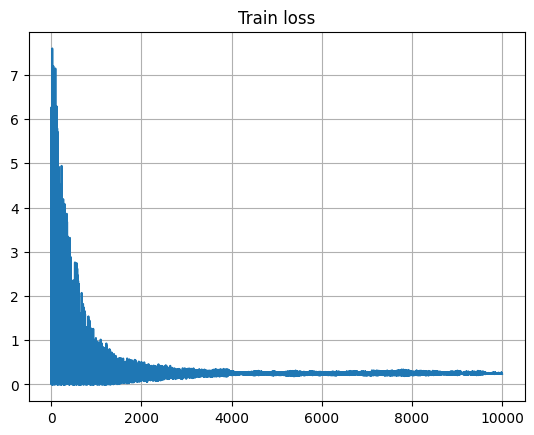

0.24282020330429077


In [21]:
model = Linear(2, 1)
model.train()

losses = []
for i in trange(len(x_train)):
  if model.W.grad is not None:
    model.W.grad.zero_()

  x, y_true = x_train[i], y_train[i]

  y_pred = model(x)

  loss = (y_pred-y_true)**2
  loss.backward()

  with torch.no_grad():
    model.W -= lr*model.W.grad

  losses.append(loss.item())


plt.plot(losses)
plt.title("Train loss")
plt.grid(True)
plt.show()

print(losses[-1])

---------------------
## __5. Changing to higher level PyTorch functionalities__
Above we saw how neural nets are trained using low-level operations. In the future, we will place more emphasis on the higher-level built-in elements of the PyTorch library, which provide a general implementation for architectural elements and algorithms often used in deep learning.

### 5.1. Definition of a model with higher level tools

In [22]:
model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

### 5.2. Training with the built-in framework

In [23]:
from torch.optim import SGD
from torch.utils.data import TensorDataset

  0%|          | 0/10 [00:00<?, ?it/s]

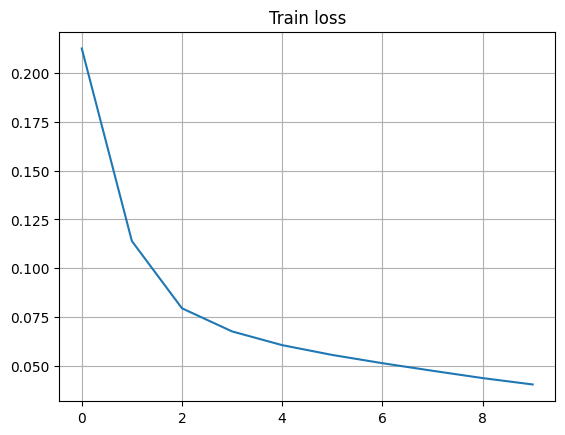

In [24]:
optimizer = SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

train_set = TensorDataset(x_train, y_train)

num_epochs = 10

losses = []
for epoch in trange(num_epochs):
  running_loss = 0.0
  for i in range(len(train_set)):
    optimizer.zero_grad()

    x, y_true = train_set[i]

    y_pred = model(x)

    loss = loss_fn(y_true, y_pred)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
  running_loss /= len(train_set)
  losses.append(running_loss)


plt.plot(losses)
plt.title("Train loss")
plt.grid(True)
plt.show()

-------------------
## __6. Training on GPUs with CUDA__

Teaching complex neural networks (and, in general, the production level use of trained models) involves high computational demand. For this reason, it may be worthwhile to run our model on a device capable of high parallelization (GPUs, DSPs, etc.) or pipelining (TPUs, VPUs, FPGAs). The most common such devices are GPUs, as they can easily be used to perform general-purpose SIMD (Single Instruction Multiple Data) operations. This use is also called a GPGPU (General Purpose GPU) application. Among the two major manufacturers, Nvidia and its CUDA GPGPU programming environment are more commonly used in the deep learning frameworks, but recently AMD RocM has also received PyTorch support.

  0%|          | 0/10 [00:00<?, ?it/s]

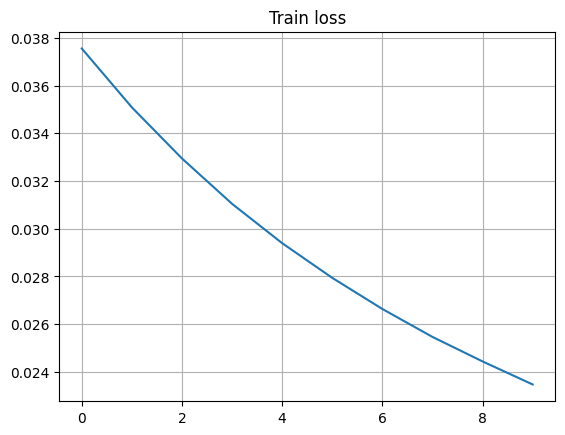

In [25]:
model = model.to("cuda")

optimizer = SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

train_set = TensorDataset(x_train, y_train)

num_epochs = 10

losses = []
for epoch in trange(num_epochs):
  running_loss = 0.0
  for i in range(len(train_set)):
    optimizer.zero_grad()

    x, y_true = train_set[i]
    x, y_true = x.to("cuda"), y_true.to("cuda")

    y_pred = model(x)

    loss = loss_fn(y_true, y_pred)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
  running_loss /= len(train_set)
  losses.append(running_loss)


plt.plot(losses)
plt.title("Train loss")
plt.grid(True)
plt.show()

-------------------
## __7. Validation__

When training neural networks, the data set is usually divided into three main parts: __training__, __validation__ and __test__ sets.
- The inputs and outputs of the teaching set are actively involved in the training. The training inputs are passed to the network and the training outputs are compared with the predictions of the network in the error function, and then the optimization takes place based on the error.
- The usage of the validation data is more indirect than that but it is still important during training. In an epoch, we calculate the loss between the predictions and the reference outputs in "eval" mode. This provides an estimate of how the network performs on data that the network is not optimized on, i.e. the generalization of the network. The only problem with this data is that in different experiments, as we tune the training hyperparameters for better performance (which includes generalization), we have the potential to tune the parameters to perform well on the validation data. That is why we use the test set.
- The test set is not used during training epochs, their role is emphasized in the evaluation of the real performance of the network. Test data can provide information about what the actual performance of the network is on data that has not played any role during training.

---------------------
### _Know your data_
The performance of deep learning techniques (especially for supervised learning) largely depends on the quality of the data. Both training, validation and test data can be considered of good quality if they cover the "interpretation range" and "value set" of the task as best and as evenly as possible. This means that during teaching, the network should preferably be prepared uniformly for all input types, and the distribution of distinguishable output types should ideally be close to uniform. During the validation and test, we also get a real picture of the performance of the network if all possible cases are included in the performance measurement.